# Lottery Predictions with Naive Bayes

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<br>

## Definitions

`ATTRIBUTES` is the size of the feature vector, the values being the last `ATTRIBUTES+1` numbers for a pick with the `ATTRIBUTES+1`th element being the class. 

In [2]:
ATTRIBUTES = 1
PICKS = 6

MIN = 1
MAX = 49

LAPLACE_M = 3

The `Pick` class encodes the column, the training vectors, the input and the classes. In `f_vec` the current input for which a prediction is made is saved.

In [3]:
class Pick:
    def __init__(self, pos, data, f_vec, classes):
        self.pos = pos
        self.data = data
        self.f_vec = f_vec
        self.classes = classes

<br>

## Data

In [4]:
def read_data():
    with open("data.txt", 'r') as file:
        return np.array([v.split('-') for v in file.read().splitlines()])

Each line is a set of 6 rolled numbers.

In [5]:
data = read_data()
print(pd.DataFrame(data))

      0   1   2   3   4   5
0     3   6  30  31  32  43
1     2  22  24  33  37  46
2     6   7  12  17  18  34
3    14  16  21  28  31  39
4    11  13  17  34  46  49
..   ..  ..  ..  ..  ..  ..
598  11  19  21  29  35  36
599  13  17  19  24  29  45
600   5   9  10  18  20  49
601   2   8  25  32  40  47
602  17  25  30  33  38  49

[603 rows x 6 columns]


The numbers in each column are treated seperately from the other columns, so 6 arrays consisting of the numbers in the respective columns are created.

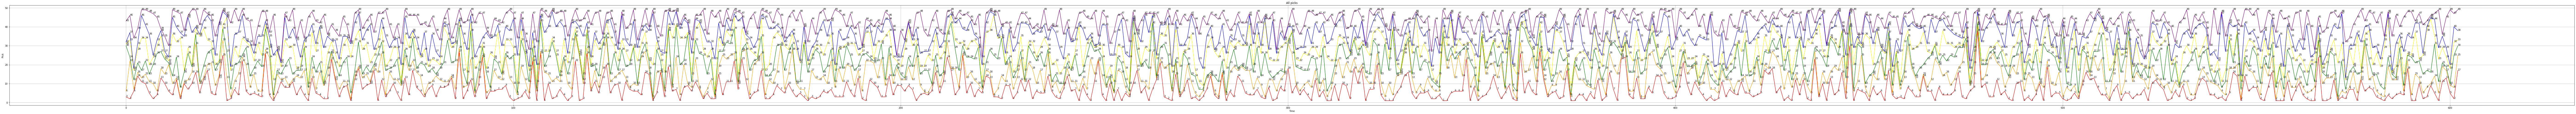

In [6]:
numbers = np.array(np.stack(read_data(), axis=1), dtype='i')

x = np.arange(numbers.shape[1])

plt.figure(figsize=(200,8))
plt.title("All picks")
plt.xlabel("Time")
plt.ylabel("Pick")
plt.grid(True)
colors = ["red", "orange", "green", "yellow", "blue", "purple"]
for i in range(numbers.shape[0]):
    plt.plot(x, numbers[i], color=colors[i])
    for j in range(numbers.shape[1]):
        plt.annotate(numbers[i][j], (j, numbers[i][j]))

plt.show()

<br>

## Processing

The `Pick` objects are initialized, one object for every column.

In [7]:
def process_data(pos, numbers):
    data_vecs = np.empty(shape=(len(numbers)-ATTRIBUTES, ATTRIBUTES+1), dtype='i')
    for k, j in enumerate(range(ATTRIBUTES, len(numbers))):
        data_vecs[k] = np.array(numbers[j-ATTRIBUTES:j+1])
        
    return Pick(pos, data_vecs, np.array(numbers[-ATTRIBUTES:], dtype='i'), np.stack(data_vecs[:,-1]))

<br>

## Learning

The dependencies are learned by calculating the probabilities. As a result of data sparsity, `LAPLACE_M` does not really have a meaningful influence.

The key in the probabilities dictionary is a tuple of (Attribute, Value, Class), which saves the probability of the occurence of a number in a attribute, given the class.

In [8]:
def learn(pick):
    probabilities = {}
    for i in range(ATTRIBUTES):
        for c in np.unique(pick.classes):
            for j in range(MIN, MAX+1):
                attr_occs = np.count_nonzero(np.logical_and(pick.data[:, i] == j, pick.data[:, -1] == c))
                if attr_occs > 0:
                    class_ocs = np.count_nonzero(pick.classes == c)
                    probabilities[(i, j, c)] = attr_occs/class_ocs
                else:
                    probabilities[(i, j, c)] = LAPLACE_M * (1/(MAX-(PICKS-1)))
    return probabilities

<br>

## Classifying

Given the latest numbers in the respective columns, the class with the biggest probability is picked as the prediction.

In [9]:
def classify(pick, probs):
    argmax = 0
    currmax = 0
    c_len = len(pick.classes)
    for c in np.unique(pick.classes):
        prob = np.count_nonzero(pick.classes == c)/c_len
        for i in range(ATTRIBUTES):
            prob *= probs[(i, pick.f_vec[i], c)]
        if prob > currmax:
            argmax, currmax = c, prob
    return argmax

<br>

## Result

In [10]:
result = np.empty(shape=(PICKS), dtype='i')
for i in range(PICKS):
    pick = process_data(i, numbers[i])
    probabilities = learn(pick)
    result[i] = classify(pick, probabilities)

print(result)

[ 3 11 17 29 34 48]
